In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [31]:
# 리뷰 코멘트가 비어있을 때, 타이틀 컬럼으로 대체하고, RNN 모델(트랜스포머 등) 활용 용이하기 위해 영어 번역 컬럼을 만들 것

# 라틴어 인코딩 해야 안 깨짐, on_bad_lines는 구조가 깨진 행만 무시하고 넘어감
rvw = pd.read_csv("order_reviews.csv", 
                  encoding='latin1', 
                  on_bad_lines='skip')

# 리뷰내용은 비었는데 제목이 있는걸 병합한 버전을 만들어보자
rvw['review_comment_message'] = rvw['review_comment_message'].fillna(rvw['review_comment_title']).copy()

# 무관 컬럼 버리기
view = rvw.drop(['review_comment_title', 'Unnamed: 3', 'Unnamed: 4'], axis= 1)

# 파일 저장
view.to_csv("cleaned_order_reviews.csv", index=False, encoding='utf-8-sig')

In [32]:
# 파일이름 변수에 저장
customers =         "olist_customers_dataset.csv"
geolocation =       "olist_geolocation_dataset.csv"
order_items=        "olist_order_items_dataset.csv"
order_payments=     "olist_order_payments_dataset.csv"
order_reviews=      "olist_order_reviews_dataset.csv"
orders=             "olist_orders_dataset.csv"
products=           "olist_products_dataset.csv"
sellers=            "olist_sellers_dataset.csv"

translation=        "product_category_name_translation.csv"

In [33]:
# 데이터 불러오기
ctm_df = pd.read_csv(customers)
geo_df = pd.read_csv(geolocation)
itm_df = pd.read_csv(order_items)
pay_df = pd.read_csv(order_payments)
rvw_df = pd.read_csv(order_reviews)
ord_df = pd.read_csv(orders)
pdt_df = pd.read_csv(products)
sel_df = pd.read_csv(sellers)

In [34]:
# 한번에 많은 컬럼을 merge하고자 할 때, 걍 참고용
from functools import reduce

dfs = [itm_df, ord_df, rvw_df]
geo = reduce(lambda left, right: pd.merge(left, right, on='order_id', how='left'), dfs)

In [35]:
# 데이터프레임별 행렬길이 확인
print(itm_df.shape, ord_df.shape ,rvw_df.shape ,pdt_df.shape)

(112650, 7) (99441, 8) (99224, 7) (32951, 9)


In [36]:
# 컬럼별 결측치유무, 데이터타입 확인
display(itm_df.info(), ord_df.info())
display(rvw_df.info() ,pdt_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status        

None

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght     

None

None

In [37]:
# 데이터별 결측치 개수 파악
display(itm_df.isna().sum(), ord_df.isna().sum(),rvw_df.isna().sum() ,pdt_df.isna().sum())

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [38]:
# 주문상태 범주 확인, 범주별 갯수 확인
ord_df.groupby('order_status')['order_id'].count()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
Name: order_id, dtype: int64

In [39]:
# 배송완료된 데이터만 보기
ord_df_c1 = ord_df[ord_df['order_status'] == 'delivered']
ord_df_c1.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [40]:
# 배송은 완료되었으나, 절차상 오류가 있는 데이터 제거
ord_df_c1.dropna(inplace=True)
ord_df_c1.isna().sum()

C:\Users\GAZI\AppData\Local\Temp\ipykernel_27756\1814885583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ord_df_c1.dropna(inplace=True)


order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [41]:
ord_df_c1[(ord_df_c1['order_purchase_timestamp'] >= '2016-10-03')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [42]:
# 결측치 있는 행 보기
display(pdt_df[pdt_df['product_weight_g'].isna()], pdt_df[pdt_df['product_category_name'].isna()])

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [43]:
# 딱히 중요한 내용 아니라고 판단됨. 결측치 제거
pdt_df_c1 = pdt_df.dropna().copy()
pdt_df_c1.isna().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

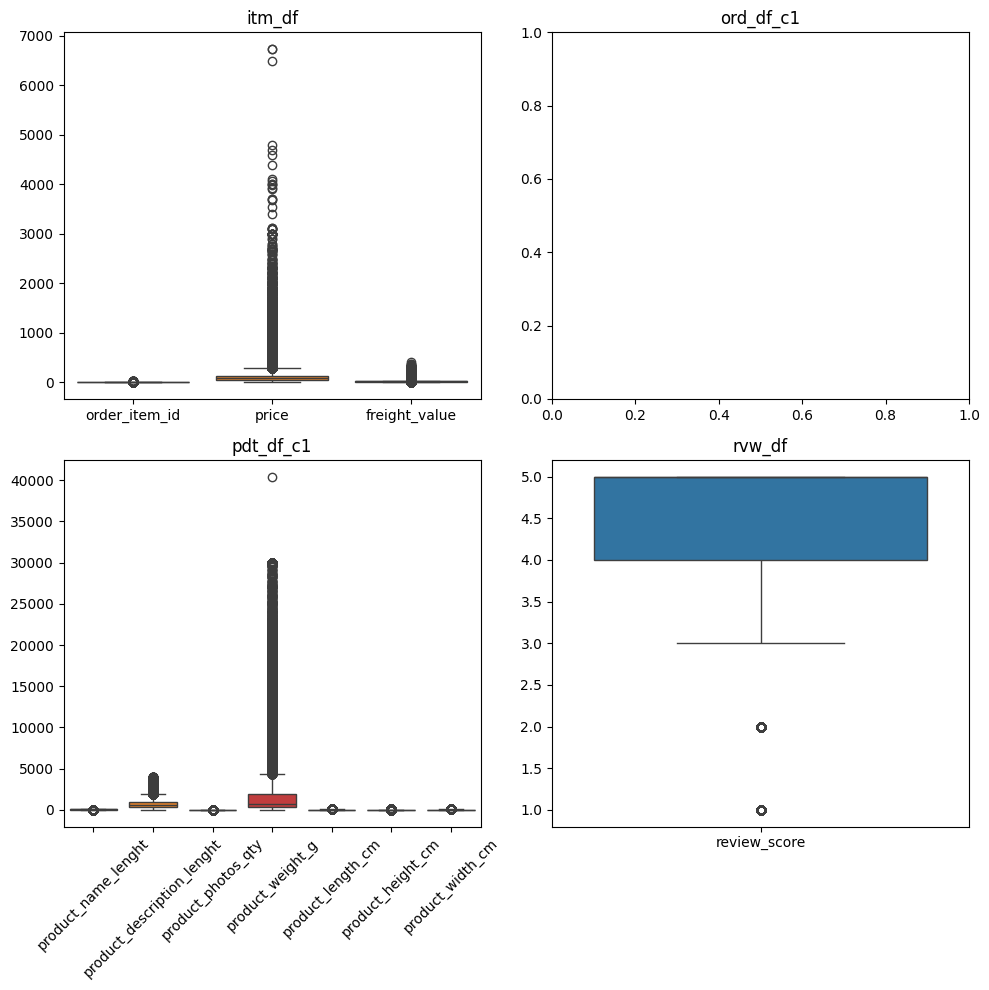

In [44]:
# boxplot 을 이용하여 이상치 체크
# ord_df_c1은 id, datetime으로 구성되어있어 시각화가 당연히 되지 않는다

# 2행 2열의 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 첫 번째 데이터프레임 박스플롯
sns.boxplot(data=itm_df, ax=axes[0,0])
axes[0,0].set_title('itm_df')

# 두 번째 데이터프레임 박스플롯
sns.boxplot(data=ord_df_c1, ax=axes[0,1])
axes[0,1].set_title('ord_df_c1')

# 세 번째 데이터프레임 박스플롯 -> 적절한 파생컬럼으로 다시하기
sns.boxplot(data=pdt_df_c1, ax=axes[1,0])
axes[1,0].set_title('pdt_df_c1')
axes[1,0].tick_params(axis='x', labelrotation=45)

# 네 번째 데이터프레임 박스플롯
sns.boxplot(data=rvw_df, ax=axes[1,1])
axes[1,1].set_title('rvw_df')

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()

# 크게 이상치랄게 없는 듯?

In [45]:
# 기본적인 join
df = itm_df.merge(ord_df_c1, on = 'order_id', how = 'left') \
                   .merge(rvw_df, on = 'order_id', how = 'left') \
                   .merge(pdt_df_c1, on = 'product_id', how = 'left')
df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-21 00:00:00,2017-09-22 10:57:03,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,2017-05-13 00:00:00,2017-05-15 11:34:13,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,2018-01-23 00:00:00,2018-01-23 16:06:31,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,2018-08-15 00:00:00,2018-08-15 16:39:01,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,2017-03-02 00:00:00,2017-03-03 10:54:59,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113309,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,...,2018-05-11 00:00:00,2018-05-14 12:53:47,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0
113310,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,...,2018-07-24 00:00:00,2018-07-25 09:25:29,informatica_acessorios,31.0,232.0,1.0,8950.0,45.0,26.0,38.0
113311,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,...,2017-10-29 00:00:00,2017-10-29 21:33:52,esporte_lazer,43.0,869.0,1.0,967.0,21.0,24.0,19.0
113312,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,...,2017-08-17 00:00:00,2017-08-18 12:24:05,informatica_acessorios,56.0,1306.0,1.0,100.0,20.0,20.0,20.0


In [46]:
# order_status가 배송완료가 아닌것들의 리뷰는 어떨까?
sdf = df[['order_id', 'shipping_limit_date', 'price', 'freight_value', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_score', 'review_comment_title', 'review_comment_message', 'product_category_name' ,'product_name_lenght', 'product_description_lenght', 'product_photos_qty']]
sdf[sdf['order_status'].isna()]

,order_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_title,review_comment_message,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty
79,002f19a65a2ddd70a090297872e6d64e,2018-03-27 13:15:27,53.98,23.31,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,Minha mercadoria não chegou e ninguém entrou e...,cama_mesa_banho,52.0,337.0,1.0
84,00310b0c75bb13015ec4d82d341865a4,2018-08-17 15:04:25,39.90,15.38,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,utilidades_domesticas,58.0,1245.0,1.0
261,00a99c50fdff7e36262caba33821875a,2018-08-21 16:35:18,52.99,22.30,NaN,NaN,NaN,NaN,NaN,NaN,5.0,"ótimo,super recomendo",comprometimento com o cliente,informatica_acessorios,59.0,1775.0,4.0
271,00ae7a8b4936674ebb701d4a23719a79,2018-05-15 15:51:32,27.90,9.26,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Não posso avaliar ainda,Não recebi o produto ainda,automotivo,52.0,1139.0,1.0
423,00ff0cf5583758e6964723e42f111bf4,2017-04-14 01:03:29,154.90,15.25,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,O produto não veio,beleza_saude,57.0,581.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112872,feebdfdb4759bd4600d52547c81b4fa8,2017-09-29 09:10:09,24.90,21.15,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,ate o momento nao foi entregue meu pedido,telefonia,54.0,1440.0,1.0
112917,ff0768e3356919b32e3d7f30baecfcfb,2018-04-10 23:10:13,379.90,20.54,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Meu produto nao chegou,"Meu produto nao chegou e eu precisava dele, vo...",informatica_acessorios,33.0,2756.0,3.0
113001,ff358345576214cc9e08488188973c84,2018-03-08 17:29:04,19.90,16.79,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,eletronicos,48.0,287.0,1.0
113045,ff536d93ae4214b4d51c2894ccfc569f,2017-12-29 12:32:10,39.00,8.27,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,Chigling,esporte_lazer,60.0,1412.0,2.0


In [ ]:
# 플랫폼상에서 일어난 총 거래액, 거래횟수 변화 보기

In [ ]:
# 17개 주요컬럼 이상치 각자 확인

In [47]:
# 늦은 배송이 정말 낮은 평가와 상관이 있는지?

In [ ]:
# @판매자 귀책 변수 추출
# 나쁜 리뷰의 원인이 '물류사'인지 '판매자'인지 구분 필요
# 판매자 과실을 잡아내는 컬럼 생성 必
# 판매자 과실 : 결제일자 - 주문승일일자 - 배송사 물건 도착 (오래 걸릴수록, 한계일 넘어갈수록 과실 有)
# 물류사 과실 : 배송사 물건 도착 - 실제 물건 도착

In [ ]:
# @판매자 발송 지연율
# 물류사에 물건을 늦게 넘긴 것은 100% 판매자 잘못
# order_items 테이블의 shipping_limit_date와
# orders 테이블의 order_delivered_carrier_date를 비교
# > order_delivered_carrier_date > shipping_limit_date인 비율.

In [ ]:
# @평균 발송 소요 시간
# order_approved_at(주문 승인)부터 order_delivered_carrier_date(집하 완료)까지 걸린 시간의 평균.

In [ ]:
# @상품 정보 충실도
# description_length, photos_qty
# 사진이 적거나(1장 이하), 설명이 너무 짧은 상품을 파는 판매자에게는 점수 패널티 부여?